## Rolling Forecast

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
def dateparser(x):
    return datetime.strptime("190"+x,"%Y-%m")#190n년 자료를 연도-월로 파싱

shampoo=pd.read_csv("data/sales-of-shampoo-over-a-three-ye.csv",
                    index_col="month",
                    parse_dates=True,
                   date_parser=dateparser)
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [3]:
# Dickey-fuller Test. stationary를 체크하는 과정을 함수로 만들기
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    result=adfuller(time_series)
    if result[1]<=0.05:
        return "Stationary, p-value : {}".format(result[1])
    else:
        return "Non-Stationary, p-value : {}".format(result[1])

adf_check(shampoo["sales"])

'Non-Stationary, p-value : 1.0'

In [4]:
# Dickey-fuller Test에서 Non-Stationary가 떴으므로 Differencing으로 stationay하게 만드는 작업 시작
# 1차 디퍼런싱
shampoo["1st diff shampoo"]=shampoo["sales"]-shampoo["sales"].shift(1)
adf_check(shampoo["1st diff shampoo"].dropna())
# 결과는 Stationary

'Stationary, p-value : 1.7998574141687034e-10'

<AxesSubplot:xlabel='month'>

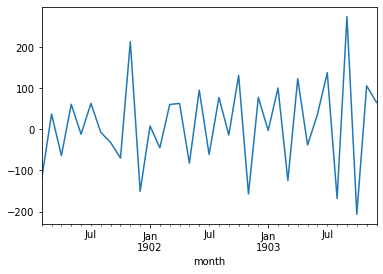

In [5]:
shampoo["1st diff shampoo"].dropna().plot()

In [6]:
# plot그렸을 때 그래도 좀 불규칙한 부분 있어서. 2차 디퍼런싱
shampoo["2nd diff shampoo"]=shampoo["1st diff shampoo"]-shampoo["1st diff shampoo"].shift(1)
adf_check(shampoo["2nd diff shampoo"].dropna())
# 결과는 Stationary

'Stationary, p-value : 0.0039063349396599245'

<AxesSubplot:xlabel='month'>

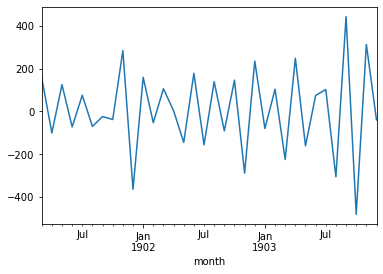

In [7]:
shampoo["2nd diff shampoo"].dropna().plot()

위 데이터에서는 Seasonality가 안보이기 때문에 그냥 바로 arima 모델을 쓸 것.
최적의 d,p,q값을 특정 파라미터를 번갈아 넣으면 확인하기

In [8]:
from statsmodels.tsa.arima_model import ARIMA

In [9]:
# d는 1,2 differencing 모두 stationary d=[1,2]
# q는 우선 0으로 두고, p와 d의 조합을 구해봄
d=[1,2]
p=list(range(0,5))
q=[0]

In [10]:
import itertools

In [11]:
pdq=list(itertools.product(p,d,q))
pdq

[(0, 1, 0),
 (0, 2, 0),
 (1, 1, 0),
 (1, 2, 0),
 (2, 1, 0),
 (2, 2, 0),
 (3, 1, 0),
 (3, 2, 0),
 (4, 1, 0),
 (4, 2, 0)]

In [12]:
'''
AIC : 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.
AIC가 최소가 되는 p,d,q 값 찾기
'''
for param in pdq:
    model=ARIMA(shampoo['sales'],order=param)
    result=model.fit()
    print("ARIMA : {}, AIC : {}".format(param,result.aic))

C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Va

ARIMA : (0, 1, 0), AIC : 430.87311187552797
ARIMA : (0, 2, 0), AIC : 461.1578257086931
ARIMA : (1, 1, 0), AIC : 406.0222895923382
ARIMA : (1, 2, 0), AIC : 423.9000860377617


C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA : (2, 1, 0), AIC : 403.62756411661564
ARIMA : (2, 2, 0), AIC : 412.9993824970403


C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA : (3, 1, 0), AIC : 404.6924591816364
ARIMA : (3, 2, 0), AIC : 410.9109265845766


C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA : (4, 1, 0), AIC : 404.7867685567421
ARIMA : (4, 2, 0), AIC : 403.94822895067733


In [13]:
d,p,q=4,2,1

In [58]:
## 데이터 셋 마련
X=shampoo['sales'].values
size=int(len(X)*0.66)
train,test=X[0:size],X[size:]
print(train,test)
# 필요한 변수 마련
history=[x for x in train]
predictions=[]

[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5] [342.3 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3
 646.9]


In [59]:
for t in range(len(test)):
    model = ARIMA(history,order=(4,2,1))
    result=model.fit(disp=0)# disp=0 설정으로 로그데이터 안나오게
    output=result.forecast()
    yhat=output[0]#output의 첫번째가 예측값
    predictions.append(yhat) # 루프를 돌면서 예측값을 추가함
    obs=test[t]
    history.append(obs)
    
# 위의 과정을 거친 후 prediction은 아래와 같음
print(predictions)

C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated

C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated

[array([399.14518073]), array([354.29658127]), array([429.96785801]), array([392.63465079]), array([420.191884]), array([397.58531263]), array([487.89263826]), array([434.16005981]), array([467.05771508]), array([568.08251587]), array([468.02436065]), array([687.49160965]), array([617.83912491])]


C:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [60]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(test,predictions))
rmse

68.51918070033352

In [61]:
shampoo['sales'].describe()
# rmse가 원본 데이터의 std의 절반 정보기 때문에 성능이 좋다고 할 수 없음

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: sales, dtype: float64

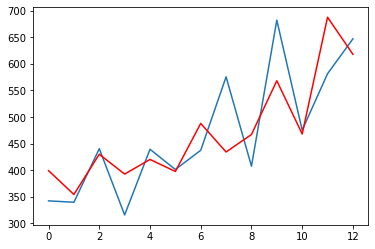

In [62]:
plt.plot(test)
plt.plot(predictions,c="r")